# TP Integrador Aprendizaje Automático I

### Librerías

In [450]:
import pandas as pd
import numpy as np
import seaborn as sns
import nbimporter
from funciones import *
from geopy.distance import geodesic
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

### Carga de datos y exploración

In [451]:
### Carga datos de dataset
### Contiene aproximadamente 10 años de observaciones diarias de variables climáticas: temperatura, dirección y velocidad del viento, humedad, presión, nubosidad, y cantidad de lluvia en mm.
### tras observar los datos del día de hoy, el objetivo es predecir las variables target:
###                                                                                     -RainFallTomorrow: cantidad de lluvia del día posterior a la observación. Problema de Regresión.
###                                                                                     -RainTomorrow: si el día siguiente llueve o no llueve. Problema de Clasificación.
file_path= 'weatherAUS.csv'
df = pd.read_csv(file_path, sep=',',engine='python')

# Lista de ubicaciones permitidas
allowed_locations = ['Adelaide', 'Canberra', 'Cobar', 'Dartmoor', 'Melbourne', 'MelbourneAirport', 'MountGambier', 'Sydney', 'SydneyAirport']

# Eliminar las demás ubicaciones del DataFrame original
df = df[df['Location'].isin(allowed_locations)]


In [452]:
### Vista de datos
df.head()

,Unnamed: 0,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
6047,6049,2009-01-01,Cobar,17.9,35.2,0.0,12.0,12.3,SSW,48.0,...,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,No,No,0.0
6048,6050,2009-01-02,Cobar,18.4,28.9,0.0,14.8,13.0,S,37.0,...,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,No,No,0.0
6049,6051,2009-01-03,Cobar,15.5,34.1,0.0,12.6,13.3,SE,30.0,...,7.0,NaN,1011.6,NaN,1.0,NaN,32.7,No,No,0.0
6050,6052,2009-01-04,Cobar,19.4,37.6,0.0,10.8,10.6,NNE,46.0,...,22.0,1012.3,1009.2,1.0,6.0,28.7,34.9,No,No,0.0
6051,6053,2009-01-05,Cobar,21.9,38.4,0.0,11.4,12.2,WNW,31.0,...,22.0,1012.7,1009.1,1.0,5.0,29.1,35.6,No,No,0.0


In [453]:
# Se elimina la primer columna con el índice
df = df.drop('Unnamed: 0', axis=1)

In [454]:
# Se analizan los tipos de datos que conforman el dataset
print(df.dtypes)

Date                 object
Location             object
MinTemp             float64
MaxTemp             float64
Rainfall            float64
Evaporation         float64
Sunshine            float64
WindGustDir          object
WindGustSpeed       float64
WindDir9am           object
WindDir3pm           object
WindSpeed9am        float64
WindSpeed3pm        float64
Humidity9am         float64
Humidity3pm         float64
Pressure9am         float64
Pressure3pm         float64
Cloud9am            float64
Cloud3pm            float64
Temp9am             float64
Temp3pm             float64
RainToday            object
RainTomorrow         object
RainfallTomorrow    float64
dtype: object


In [455]:
# Se convierte la columna 'Date' de string (object) a datetime
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

# Se toma como fecha base la mínima fecha del df
fecha_base = df['Date'].min()

# Se calcula el número de días desde la fecha base
df['Date'] = (df['Date'] - fecha_base).dt.days


In [456]:
#Se reemplaza 'Yes' por 1 y 'No' por 0 en las columnas RainToday y RainTomorrow
# errors='coerce' permite conservar los nan aún cambiando el tipo de datos a booleano
df['RainToday'] = pd.to_numeric(df['RainToday'].replace({'Yes': 1, 'No': 0}), errors='coerce').astype('boolean')
df['RainTomorrow'] = pd.to_numeric(df['RainTomorrow'].replace({'Yes': 1, 'No': 0}), errors='coerce').astype('boolean')

C:\Users\julia\AppData\Local\Temp\ipykernel_6164\84528137.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['RainToday'] = pd.to_numeric(df['RainToday'].replace({'Yes': 1, 'No': 0}), errors='coerce').astype('boolean')
C:\Users\julia\AppData\Local\Temp\ipykernel_6164\84528137.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['RainTomorrow'] = pd.to_numeric(df['RainTomorrow'].replace({'Yes': 1, 'No': 0}), errors='coerce').astype('boolean')


In [457]:
#Se mapean las direcciones dadas ('SSW', 'S', 'SE', etc.) a números del 0 al 15 según las agujas del reloj
directions_mapping = {
    'N': 0,
    'NNE': 1,
    'NE': 2,
    'ENE': 3,
    'E': 4,
    'ESE': 5,
    'SE': 6,
    'SSE': 7,
    'S': 8,
    'SSW': 9,
    'SW': 10,
    'WSW': 11,
    'W': 12,
    'WNW': 13,
    'NW': 14,
    'NNW': 15
}

In [458]:
# Se reemplaza en df los nuevos valores
df['WindGustDir'] = df['WindGustDir'].replace(directions_mapping)
df['WindDir9am'] = df['WindDir9am'].replace(directions_mapping)
df['WindDir3pm'] = df['WindDir3pm'].replace(directions_mapping)

C:\Users\julia\AppData\Local\Temp\ipykernel_6164\216544107.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['WindGustDir'] = df['WindGustDir'].replace(directions_mapping)
C:\Users\julia\AppData\Local\Temp\ipykernel_6164\216544107.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['WindDir9am'] = df['WindDir9am'].replace(directions_mapping)
C:\Users\julia\AppData\Local\Temp\ipykernel_6164\216544107.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the o

In [459]:
df.describe()

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainfallTomorrow
count,28233.000000,27663.000000,27675.000000,27247.000000,23880.000000,21520.000000,26588.000000,26591.000000,26585.000000,27796.000000,...,27893.000000,27293.000000,27343.000000,27394.000000,27404.000000,18866.000000,18683.000000,27648.000000,27657.000000,27248.000000
mean,1913.110367,11.263319,21.902078,2.050369,4.826499,6.891129,7.711110,41.835471,7.376378,8.048928,...,20.023052,68.766350,50.497385,1018.249325,1016.149624,4.668557,4.732805,15.477127,20.408345,2.049347
std,948.862211,5.709936,6.693168,6.384560,3.707995,3.867622,4.694183,14.186300,5.054644,4.503144,...,8.979409,18.730306,19.944931,7.423776,7.267376,2.807571,2.628154,5.701031,6.532302,6.383931
min,0.000000,-8.000000,4.100000,0.000000,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,...,0.000000,5.000000,1.000000,982.300000,984.900000,0.000000,0.000000,-1.300000,3.700000,0.000000
25%,1082.000000,7.400000,16.600000,0.000000,2.200000,3.800000,4.000000,31.000000,2.000000,4.000000,...,13.000000,57.000000,37.000000,1013.300000,1011.300000,1.000000,2.000000,11.400000,15.400000,0.000000
50%,1955.000000,10.900000,21.000000,0.000000,4.000000,7.400000,8.000000,39.000000,8.000000,8.000000,...,19.000000,70.000000,50.000000,1018.400000,1016.300000,6.000000,6.000000,15.000000,19.500000,0.000000
75%,2739.000000,15.200000,26.200000,1.000000,6.600000,10.000000,12.000000,50.000000,12.000000,12.000000,...,26.000000,83.000000,64.000000,1023.300000,1021.100000,7.000000,7.000000,19.125000,24.500000,1.000000
max,3523.000000,33.900000,46.800000,119.400000,86.200000,14.300000,15.000000,122.000000,15.000000,15.000000,...,76.000000,100.000000,100.000000,1040.600000,1037.900000,9.000000,8.000000,38.600000,46.100000,119.400000


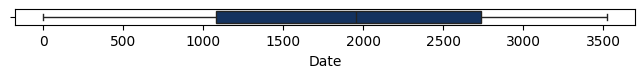

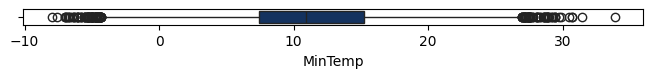

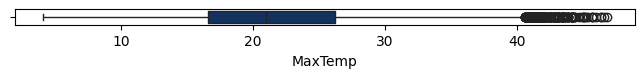

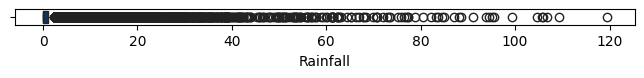

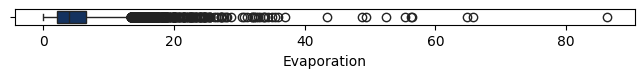

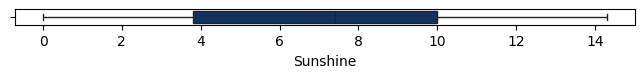

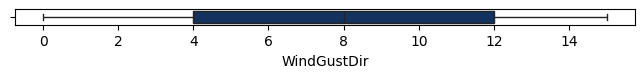

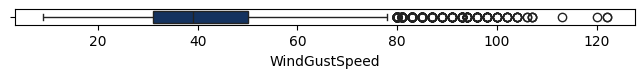

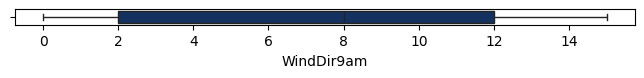

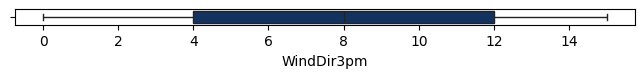

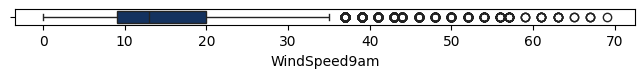

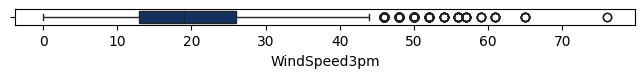

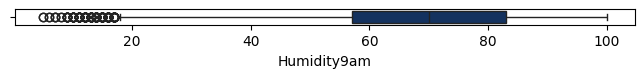

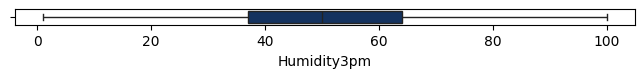

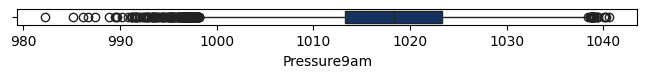

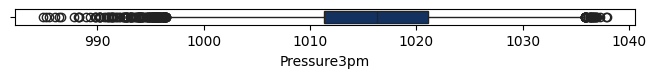

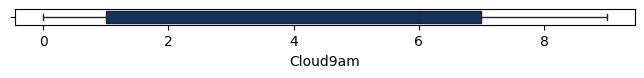

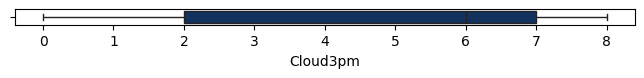

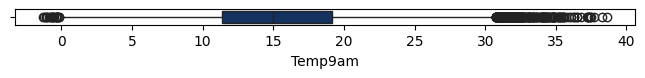

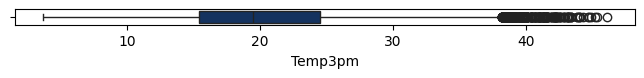

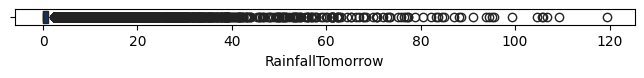

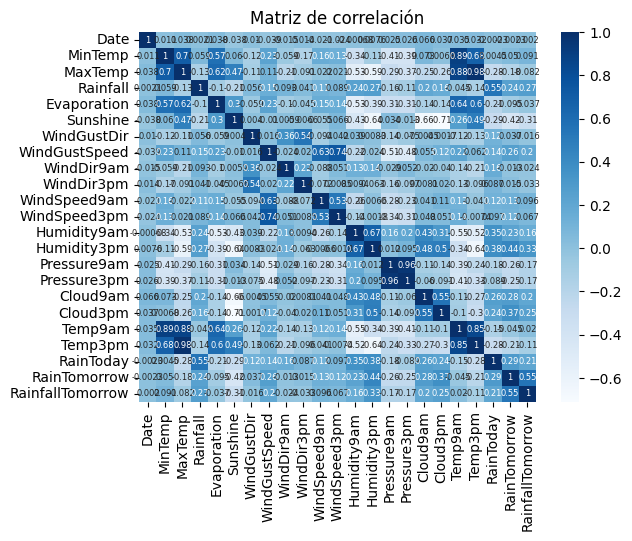

In [460]:
explorar(df)

### Partición del Dataframe

In [461]:
# Se chequea que todas las fechas tengan un valor
df['Date'].isna().sum()

0

Se particiona el df en df_train y df_test en una proporción aproximada de 80% 20%, correspondiendo los del df_train a los datos cronológicamente más antiguos.

In [462]:
# Ordenamiento por la columna 'Date'
df = df.sort_values('Date')

# Calcular el índice que corresponde al 80% del DataFrame
index_at_80_percent = int(len(df) * 0.8)

# Usar el índice para obtener la fecha en ese punto
date_at_80_percent = df.iloc[index_at_80_percent]['Date']

# Crear df_train y df_test basado en esta fecha
df_train = df[df['Date'] <= date_at_80_percent]
df_test = df[df['Date'] > date_at_80_percent]

# Mostrar el número de registros en cada conjunto
print(f"Entrenamiento: {len(df_train)} registros")
print(f"Prueba: {len(df_test)} registros")
print(f"Suma de registro Entrenamiento y Prueba: {len(df_test)+len(df_train)} registros")
print(f"Cantidad total de registros en df original: {df.shape[0]} registros")


Entrenamiento: 22590 registros
Prueba: 5643 registros
Suma de registro Entrenamiento y Prueba: 28233 registros
Cantidad total de registros en df original: 28233 registros


### Análisis de valores nulos

#### Primeros análisis

Se cuenta la cantidad de filas con al menos un valor nan. Dicho valor debe ser menor al 5% del total de registros. Se observa que el segundo valor supera al primero, por lo que deberá analizarse el tratamiento a dar a los valores nan para su reemplazo.

Observación: todo el análisis se hará sobre el df_train.

In [463]:
print(f'Número máximo de filas para eliminar: {int(0.05 * df_train.shape[0])}')

Número máximo de filas para eliminar: 1129


In [464]:
# Contar filas que contienen al menos un valor NaN
nan_rows_count = df_train.isna().any(axis=1).sum()

# Imprimir el resultado
print(f'Número de filas con al menos un valor NaN: {nan_rows_count}')


Número de filas con al menos un valor NaN: 11516


In [465]:
### Cantidad de valores faltantes.
df_train.isna().sum().sort_values(ascending=False)

Cloud3pm            7469
Cloud9am            7179
Sunshine            3962
Evaporation         2016
WindGustDir         1571
WindGustSpeed       1568
WindDir9am          1415
RainfallTomorrow     742
Rainfall             742
RainToday            742
RainTomorrow         742
Pressure9am          625
Pressure3pm          618
Humidity9am          605
Humidity3pm          561
WindDir3pm           414
Temp9am              372
Temp3pm              366
MinTemp              357
WindSpeed9am         350
MaxTemp              344
WindSpeed3pm         336
Location               0
Date                   0
dtype: int64

Se analiza a continuación cada variable, con su variable más correlacionada, y la cantidad de nulos de cada una:

In [466]:
df_con_nan=df_train
analisis_nan(df_con_nan)

g:\Mi unidad\TUIA\IA4.1 AA I\Trabajo Práctico Integrador\AA1-TUIA-Garcia-Herrera\funciones.py:117: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_nan = pd.concat([df_nan, pd.DataFrame({'Columna': [columna],


,Columna,Max_Abs_Correlacion,Valor_Correlacion,Valores_NaN
0,Date,Pressure3pm,0.072729,0
1,MinTemp,Temp9am,0.892961,357
2,MaxTemp,Temp3pm,0.982767,344
3,Rainfall,RainToday,0.550871,742
4,Evaporation,Temp9am,0.652501,2016
5,Sunshine,Cloud3pm,-0.708560,3962
6,WindGustDir,WindDir3pm,0.545980,1571
7,WindGustSpeed,WindSpeed3pm,0.742479,1568
8,WindDir9am,WindGustDir,0.368278,1415
9,WindDir3pm,WindGustDir,0.545980,414


In [467]:
# Se reemplazan los nan con la siguiente función, para las variables más correlacionadas
recrear_nan(df_train,'MinTemp','Temp9am')
analisis_nan(df_train)

g:\Mi unidad\TUIA\IA4.1 AA I\Trabajo Práctico Integrador\AA1-TUIA-Garcia-Herrera\funciones.py:117: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_nan = pd.concat([df_nan, pd.DataFrame({'Columna': [columna],


,Columna,Max_Abs_Correlacion,Valor_Correlacion,Valores_NaN
0,Date,Pressure3pm,0.072729,0
1,MinTemp,Temp9am,0.892996,347
2,MaxTemp,Temp3pm,0.982767,344
3,Rainfall,RainToday,0.550871,742
4,Evaporation,Temp9am,0.652501,2016
5,Sunshine,Cloud3pm,-0.708560,3962
6,WindGustDir,WindDir3pm,0.545980,1571
7,WindGustSpeed,WindSpeed3pm,0.742479,1568
8,WindDir9am,WindGustDir,0.368278,1415
9,WindDir3pm,WindGustDir,0.545980,414


Se observa que la mayoría de las variables no presenta una fuerte correlación con las demás, por lo que no resulta válido reconstruir los valores nulos mediante regresión lineal.
Es por eso que se hace a continuación un análisis más detallado para estas variables.

#### Matriz de distancias geodésicas

Se construye una matriz con las distancias entre ciudades, que ayudará a comprender la posibilidad de adoptar valores de ciudades aledañas:

In [468]:
# Coordenadas de las ciudades
cities_coords = {
    'Adelaide': (-34.9285, 138.6007),
    'Canberra': (-35.2809, 149.1300),
    'Cobar': (-31.4983, 145.8344),
    'Dartmoor': (-37.9225, 141.2760),
    'Melbourne': (-37.8136, 144.9631),
    'MelbourneAirport': (-37.6690, 144.8410),
    'MountGambier': (-37.8284, 140.7804),
    'Sydney': (-33.8688, 151.2093),
    'SydneyAirport': (-33.9399, 151.1753)
}

# Crear un DataFrame vacío
dist_matrix = pd.DataFrame(index=cities_coords.keys(), columns=cities_coords.keys())

# Calcular las distancias y llenar la matriz
for city1 in cities_coords:
    for city2 in cities_coords:
        dist = geodesic(cities_coords[city1], cities_coords[city2]).kilometers
        dist_matrix.at[city1, city2] = round(dist, 2)

# Mostrar la matriz de distancias
print(dist_matrix)


                 Adelaide Canberra   Cobar Dartmoor Melbourne  \
Adelaide              0.0   960.32  773.97   409.76    654.36   
Canberra           960.32      0.0  519.56   761.08    467.02   
Cobar              773.97   519.56     0.0   825.72    705.11   
Dartmoor           409.76   761.08  825.72      0.0    324.63   
Melbourne          654.36   467.02  705.11   324.63       0.0   
MelbourneAirport   637.49   466.79  690.56   315.23     19.32   
MountGambier       376.54   798.82  840.92    44.84    368.24   
Sydney            1164.53   246.85   568.4   1002.5    713.86   
SydneyAirport     1160.17   239.41   569.1   995.89    706.42   

                 MelbourneAirport MountGambier   Sydney SydneyAirport  
Adelaide                   637.49       376.54  1164.53       1160.17  
Canberra                   466.79       798.82   246.85        239.41  
Cobar                      690.56       840.92    568.4         569.1  
Dartmoor                   315.23        44.84   1002.5      

#### Análisis nan por distancias

Se crea la función general procesar_geo_nan, que permite analizar y reemplazar los datos nulos por aquellos del mismo día para ciudades vecinas, con un radio de km a definir.

Luego, se hace un análisis pormenorizado de los demás valores nulos, reemplazando con datos de ciudades más lejanas pero en donde se observa una buena correlación de los datos, utilizando gráficos de dispersión para comparar entre ciudades.

In [469]:
df_train_cleared = procesar_geo_nan(df_train, dist_matrix, cities_coords, 100)

Procesando las siguientes columnas: Index(['Cloud3pm', 'Cloud9am', 'Evaporation', 'Humidity3pm', 'Humidity9am',
       'MaxTemp', 'MinTemp', 'Pressure3pm', 'Pressure9am', 'Rainfall',
       'RainfallTomorrow', 'Sunshine', 'Temp3pm', 'Temp9am', 'WindDir3pm',
       'WindDir9am', 'WindGustDir', 'WindGustSpeed', 'WindSpeed3pm',
       'WindSpeed9am'],
      dtype='object')
El rango fijado para ciudades cercanas es (km): 100
Analizando la variable: Cloud3pm
Resultado del análisis geográfico:
            Location  Cloud3pm NaN Count      Nearest City Distance (km)
0          Adelaide                2565      MountGambier        376.54
1          Dartmoor                2381      MountGambier         44.84
2          Canberra                 965     SydneyAirport        239.41
3         Melbourne                 899  MelbourneAirport         19.32
4            Sydney                 563     SydneyAirport          8.49
5             Cobar                  75          Canberra        519.56
6 

Resultado del análisis geográfico:
     Location  Rainfall NaN Count      Nearest City Distance (km)
0  Melbourne                 551  MelbourneAirport         19.32
1   Adelaide                  98      MountGambier        376.54
2   Dartmoor                  65      MountGambier         44.84
3   Canberra                  15     SydneyAirport        239.41
4     Sydney                   7     SydneyAirport          8.49
5      Cobar                   6          Canberra        519.56
Procesando la localidad: Melbourne
La ciudad más cercana a Melbourne es MelbourneAirport a 19.32 km.
La cantidad de datos reemplazados fue 551
No se encontró ciudad cercana en el rango deseado para Adelaide
Procesando la localidad: Dartmoor
La ciudad más cercana a Dartmoor es MountGambier a 44.84 km.
La cantidad de datos reemplazados fue 65
No se encontró ciudad cercana en el rango deseado para Canberra
Procesando la localidad: Sydney
La ciudad más cercana a Sydney es SydneyAirport a 8.49 km.
La cantidad

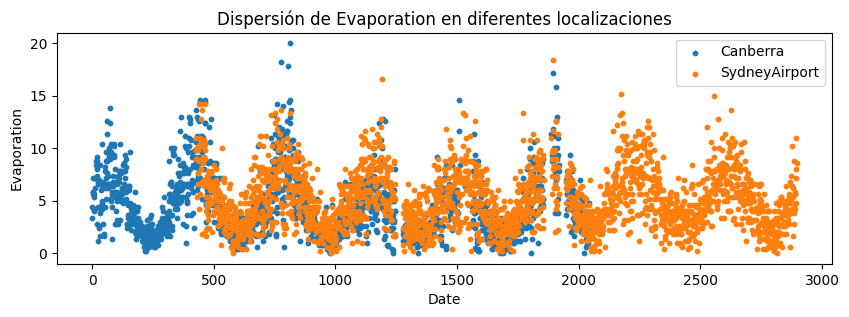

,Location,Evaporation NaN Count,Nearest City,Distance (km)
0,Canberra,976,SydneyAirport,239.41
1,Adelaide,861,MountGambier,376.54
2,Cobar,77,Canberra,519.56
3,Sydney,37,SydneyAirport,8.49
4,SydneyAirport,32,Sydney,8.49
5,MountGambier,16,Dartmoor,44.84
6,Dartmoor,15,MountGambier,44.84
7,Melbourne,1,MelbourneAirport,19.32
8,MelbourneAirport,1,Melbourne,19.32


In [470]:
variable='Evaporation'
location='Canberra'
location_near='SydneyAirport'
graf_dispersion_comparativa(df_train_cleared, [location, location_near], 'Date',variable)
analisis_geo_nan(df_train_cleared, variable, dist_matrix, cities_coords)

In [504]:
df_train_cleared = recrear_geo_nan(df_train_cleared,'Cobar','Canberra','Sunshine')
df_train_cleared = recrear_geo_nan(df_train_cleared,'Canberra','Melbourne','Sunshine')
df_train_cleared = recrear_geo_nan(df_train_cleared,'Adelaide','Dartmoor','Sunshine')
df_train_cleared = recrear_geo_nan(df_train_cleared,'Canberra','SydneyAirport','Evaporation')
df_train_cleared = recrear_geo_nan(df_train_cleared,'Sydney','SydneyAirport','WindGustSpeed')
df_train_cleared = recrear_geo_nan(df_train_cleared,'Canberra','SydneyAirport','Pressure9am')
df_train_cleared = recrear_geo_nan(df_train_cleared,'Canberra','SydneyAirport','Pressure3pm')
df_train_cleared = recrear_geo_nan(df_train_cleared,'Canberra','SydneyAirport','WindSpeed9am')
df_train_cleared = recrear_geo_nan(df_train_cleared,'Canberra','SydneyAirport','WindSpeed3pm')

La cantidad de datos reemplazados fue 0
La cantidad de datos reemplazados fue 0
La cantidad de datos reemplazados fue 0
La cantidad de datos reemplazados fue 0
La cantidad de datos reemplazados fue 0
La cantidad de datos reemplazados fue 0
La cantidad de datos reemplazados fue 0
La cantidad de datos reemplazados fue 0
La cantidad de datos reemplazados fue 0


In [505]:
# Crear una copia del DataFrame sin las columnas 'RainfallTomorrow' y 'RainTomorrow'
df_filtered = df_train_cleared.drop(columns=['RainfallTomorrow', 'RainTomorrow'])

# Contar filas que contienen al menos un valor NaN en el DataFrame filtrado
nan_rows_count_filtered = df_filtered.isna().any(axis=1).sum()
print(f'Número de filas con al menos un valor NaN (sin contar RainTomorrow y RainfallTomorrow): {nan_rows_count_filtered}')

# Cantidad de valores faltantes en el DataFrame filtrado, ordenados de mayor a menor
nan_count_filtered = df_filtered.isna().sum().sort_values(ascending=False)
print(nan_count_filtered)

Número de filas con al menos un valor NaN: 3386
Evaporation         1055
WindDir9am           878
WindGustDir          792
WindGustSpeed        790
RainTomorrow         742
RainToday            742
WindDir3pm           272
RainfallTomorrow     119
Rainfall             119
Cloud9am              85
Humidity9am           77
Sunshine              55
Cloud3pm              44
Pressure9am           35
Pressure3pm           32
Humidity3pm           29
WindSpeed9am          28
Temp9am               27
WindSpeed3pm          19
Temp3pm               17
MinTemp                8
MaxTemp                5
Location               0
Date                   0
dtype: int64


#### Análisis nan para Cloud9am

##### Método general

Inicialmente se considera como criterio para rellenar nulos tomar la media de los valores de Cloud3pm del día anterior y Cloud3pm del mismo día:

In [506]:
# Definir n, el valor para los pesos
n = 2  # Puedes ajustar este valor según lo que consideres apropiado

# Ordenar el DataFrame por 'Location' y 'Date' para mantener la consistencia
df_train_cleared = df_train_cleared.sort_values(['Location', 'Date'])

# Crear una columna para 'Cloud3pm' del día anterior, solo dentro de la misma localidad
df_train_cleared['Cloud3pm_prev_day'] = df_train_cleared.groupby('Location')['Cloud3pm'].shift(1)

# Calcular 'Cloud9am_predic' ajustando con los pesos específicos
df_train_cleared['Cloud9am_predic'] = (df_train_cleared['Cloud3pm_prev_day'] / n) + \
                                      (df_train_cleared['Cloud3pm'] * ((n-1) / n))

# Filtrar las filas donde 'Cloud9am' no es nulo para calcular el MAE
cloud9am_actual = df_train_cleared[df_train_cleared['Cloud9am'].notna()]['Cloud9am']
cloud9am_predicted = df_train_cleared[df_train_cleared['Cloud9am'].notna()]['Cloud9am_predic']

# Eliminar las columnas 'Cloud3pm_prev_day' y 'Cloud9am_predic'
df_train_cleared = df_train_cleared.drop(columns=['Cloud3pm_prev_day', 'Cloud9am_predic'])

# Calcular el MAE
mae = (cloud9am_actual - cloud9am_predicted).abs().mean()
print(f"El Error Medio Absoluto (MAE) entre 'Cloud9am' y 'Cloud9am_predic' es: {mae}")

El Error Medio Absoluto (MAE) entre 'Cloud9am' y 'Cloud9am_predic' es: 1.6708219972347353


Se varía el valor de n para darle mayor peso al valor de Cloud3pm del mismo día. Se llega a la conclusión que el error mae disminuye conforme n aumenta, lo que es igual a igualar a Cloud9am con el valor de Cloud3pm del mismo día.

In [507]:
# Definir n, el valor para los pesos
n = 100000  # Puedes ajustar este valor según lo que consideres apropiado

# Ordenar el DataFrame por 'Location' y 'Date' para mantener la consistencia
df_train_cleared = df_train_cleared.sort_values(['Location', 'Date'])

# Crear una columna para 'Cloud3pm' del día anterior, solo dentro de la misma localidad
df_train_cleared['Cloud3pm_prev_day'] = df_train_cleared.groupby('Location')['Cloud3pm'].shift(1)

# Calcular 'Cloud9am_predic' ajustando con los pesos específicos
df_train_cleared['Cloud9am_predic'] = (df_train_cleared['Cloud3pm_prev_day'] / n) + \
                                      (df_train_cleared['Cloud3pm'] * ((n-1) / n))

# Filtrar las filas donde 'Cloud9am' no es nulo para calcular el MAE
cloud9am_actual = df_train_cleared[df_train_cleared['Cloud9am'].notna()]['Cloud9am']
cloud9am_predicted = df_train_cleared[df_train_cleared['Cloud9am'].notna()]['Cloud9am_predic']

# Eliminar las columnas 'Cloud3pm_prev_day' y 'Cloud9am_predic'
df_train_cleared = df_train_cleared.drop(columns=['Cloud3pm_prev_day', 'Cloud9am_predic'])

# Calcular el MAE
mae = (cloud9am_actual - cloud9am_predicted).abs().mean()
print(f"El Error Medio Absoluto (MAE) entre 'Cloud9am' y 'Cloud9am_predic' es: {mae}")

El Error Medio Absoluto (MAE) entre 'Cloud9am' y 'Cloud9am_predic' es: 1.5333617711074439


Se reemplazan entonces los valores nan Cloud9am por Cloud3pm:

In [508]:
df_train_cleared['Cloud9am'] = df_train_cleared['Cloud9am'].fillna(df['Cloud3pm'])

No se observa una disminución considerable de nulos, debido a que simultáneamente los valores de cloud3pm lo son también. A continuación se discriminan los valores por ciudades:

In [509]:
analisis_geo_nan(df_train_cleared, 'Cloud9am', dist_matrix, cities_coords)

,Location,Cloud9am NaN Count,Nearest City,Distance (km)
0,MountGambier,7,Dartmoor,44.84
1,Cobar,6,Canberra,519.56
2,Dartmoor,5,MountGambier,44.84
3,Sydney,1,SydneyAirport,8.49
4,SydneyAirport,1,Sydney,8.49


Se analiza reemplazar por valores de ciudades cercanas, pero las correlaciones observadas no son suficientes para considerar válido este método:

In [510]:
comparar_datos(df_train_cleared, 'Adelaide', 'MountGambier', 'Cloud9am')
comparar_datos(df_train_cleared, 'Adelaide', 'Dartmoor', 'Cloud9am')
comparar_datos(df_train_cleared, 'Canberra', 'Sydney', 'Cloud9am')
comparar_datos(df_train_cleared, 'Canberra', 'Cobar', 'Cloud9am')
comparar_datos(df_train_cleared, 'Canberra', 'Melbourne', 'Cloud9am')

Correlación entre Adelaide y MountGambier para Cloud9am: 0.1605383586912572
Correlación entre Adelaide y Dartmoor para Cloud9am: 0.16226422073720176
Correlación entre Canberra y Sydney para Cloud9am: 0.32466250728023544
Correlación entre Canberra y Cobar para Cloud9am: 0.2549619035044445
Correlación entre Canberra y Melbourne para Cloud9am: 0.08716159637229631


##### Método para Adelaide

Se grafican los valores de Cloud9am por date para Adelaide, y se observan faltantes para fechas menores a 950 y mayores a 1350 aproximadamente.

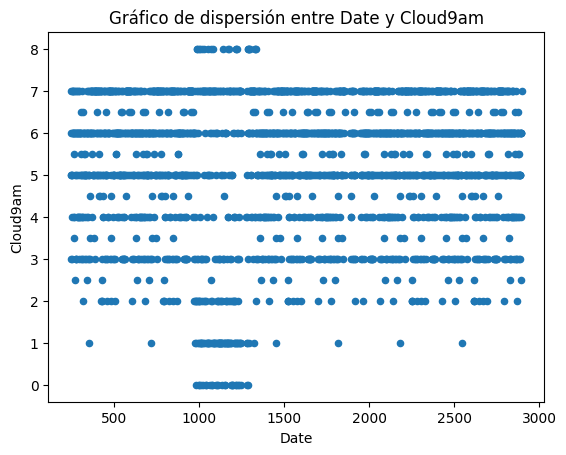

In [511]:
graf_dispersion(df_train_cleared[df_train_cleared['Location'] == 'Adelaide'],'Date','Cloud9am')

Se estudia qué valores se dieron para cada fecha determinada los años sucesivos y/o previos, y se toma la moda y la mediana. Se adoptan los valores predichos por la mediana por presentar un menor mae, y se reemplazan los datos en el dataframe.

In [512]:
def predict_variable(df, location, variable, method='mode'):
    # Filtrar los datos para la localidad especificada
    local_data = df[df['Location'] == location].copy()

    # Preparar la columna para las predicciones
    prediction_column = f'{variable}_predic'
    local_data[prediction_column] = np.nan  

    # Iterar sobre cada día único en los datos de la localidad
    for day in local_data['Date'].unique():
        # Calcular los rangos de fechas para años anteriores y posteriores
        previous_years = day + np.arange(-10, 1) * 365
        next_years = day + np.arange(1, 11) * 365

        # Filtrar los datos para los rangos calculados
        historical_data = df[(df['Date'].isin(previous_years) | df['Date'].isin(next_years))]
        
        if method == 'mode':
            # Uso de moda para predicción
            mode_value = historical_data[variable].mode()
            # Si hay una moda disponible, usar el primer valor (en caso de múltiples modas)
            if not mode_value.empty:
                local_data.loc[local_data['Date'] == day, prediction_column] = mode_value[0]
        elif method == 'median':
            # Uso de mediana para predicción
            median_value = historical_data[variable].median()
            # Asignar la mediana si es un número válido (no NaN)
            if not np.isnan(median_value):
                local_data.loc[local_data['Date'] == day, prediction_column] = median_value

    # Calculando el MAE
    valid_data = local_data.dropna(subset=[variable, prediction_column])
    if valid_data.shape[0] > 0:
        mae = (valid_data[variable] - valid_data[prediction_column]).abs().mean()
        print(f"El Error Medio Absoluto (MAE) para {location} usando {method} es: {mae}")
    else:
        print(f"No hay suficientes datos para calcular el MAE en {location}.")

    return local_data

# Uso de la función con moda
local_data=predict_variable(df_train_cleared, 'Adelaide', 'Cloud9am', method='mode')

# Uso de la función con mediana
local_data=predict_variable(df_train_cleared, 'Adelaide', 'Cloud9am', method='median')


El Error Medio Absoluto (MAE) para Adelaide usando mode es: 1.211111111111111
El Error Medio Absoluto (MAE) para Adelaide usando median es: 0.3200779727095517


In [ ]:
def update_missing_values(df_main, local_data, variable):
    """
    Actualiza los valores faltantes de una variable en el DataFrame principal usando
    los valores predictivos provenientes de un DataFrame local.
    
    Parámetros:
        df_main (pd.DataFrame): DataFrame principal donde se actualizarán los datos.
        local_data (pd.DataFrame): DataFrame local con datos predictivos.
        variable (str): Nombre de la variable a actualizar.
    """
    # Asegurarse de que el DataFrame local solo contenga las columnas necesarias
    if 'predic' not in variable:
        variable_predic = f'{variable}_predic'
    else:
        variable_predic = variable
        
    local_data = local_data[['Date', 'Location', variable_predic]]

    # Fusionar df_main con local_data para obtener los valores predictivos
    df_main = df_main.merge(local_data, on=['Date', 'Location'], how='left')

    # Actualizar los valores NaN en la variable específica usando los valores predictivos
    df_main[variable] = df_main[variable].fillna(df_main[variable_predic])

    # Opcional: Eliminar la columna predictiva si ya no es necesaria
    df_main.drop(columns=variable_predic, inplace=True)

    return df_main

In [ ]:
df_train_cleared = update_missing_values(df_train_cleared, local_data, 'Cloud9am')

##### Método para Canberra

Se grafican los valores de Cloud9am por date para Canberra, y se observan faltantes entre 650 y 850, principalmente.

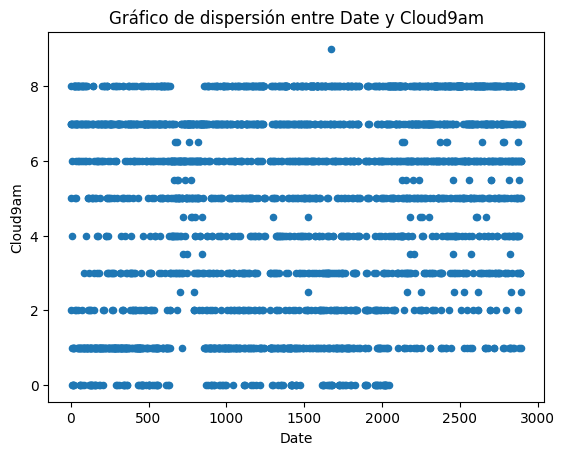

In [514]:
graf_dispersion(df_train_cleared[df_train_cleared['Location'] == 'Canberra'],'Date','Cloud9am')

Se estudia qué valores se dieron para cada fecha determinada los años sucesivos y/o previos, y se toma la moda y la mediana. Se adoptan los valores predichos por la mediana por presentar un menor mae, y se reemplazan los datos en el dataframe.

In [515]:
# Uso de la función con moda
local_data=predict_variable(df_train_cleared, 'Canberra', 'Cloud9am', method='mode')

# Uso de la función con mediana
local_data=predict_variable(df_train_cleared, 'Canberra', 'Cloud9am', method='median')

El Error Medio Absoluto (MAE) para Canberra usando mode es: 2.2485754985754984
El Error Medio Absoluto (MAE) para Canberra usando median es: 1.8780270655270654


In [516]:
df_train_cleared = update_missing_values(df_train_cleared, local_data, 'Cloud9am')

#### Análisis nan para Cloud3pm

##### Método general

Inicialmente se considera como criterio para rellenar nulos tomar la media de los valores de Cloud9am del día posterior y Cloud9am del mismo día:

In [517]:
# Definir n, el valor para los pesos
n = 2  # Puedes ajustar este valor según lo que consideres apropiado

# Ordenar el DataFrame por 'Location' y 'Date' para mantener la consistencia
df_train_cleared = df_train_cleared.sort_values(['Location', 'Date'])

# Crear una columna para 'Cloud9am' del día siguiente, solo dentro de la misma localidad
df_train_cleared['Cloud9am_next_day'] = df_train_cleared.groupby('Location')['Cloud9am'].shift(-1)

# Calcular 'Cloud9am_predic' ajustando con los pesos específicos
df_train_cleared['Cloud9am_predic'] = (df_train_cleared['Cloud9am'] * ((n-1) / n)) + \
                                      (df_train_cleared['Cloud9am_next_day'] / n)

# Filtrar las filas donde 'Cloud9am' no es nulo para calcular el MAE
cloud9am_actual = df_train_cleared[df_train_cleared['Cloud9am'].notna()]['Cloud9am']
cloud9am_predicted = df_train_cleared[df_train_cleared['Cloud9am'].notna()]['Cloud9am_predic']

# Eliminar las columnas 'Cloud9am_next_day' y 'Cloud9am_predic'
df_train_cleared = df_train_cleared.drop(columns=['Cloud9am_next_day', 'Cloud9am_predic'])

# Calcular el MAE
mae = (cloud9am_actual - cloud9am_predicted).abs().mean()
print(f"El Error Medio Absoluto (MAE) entre 'Cloud9am' y 'Cloud9am_predic' es: {mae}")

El Error Medio Absoluto (MAE) entre 'Cloud9am' y 'Cloud9am_predic' es: 1.1375493545095603


Se varía el valor de n para darle mayor peso al valor de Cloud3pm del mismo día. Se llega a la conclusión que el error mae disminuye conforme n aumenta, lo que es igual a igualar a Cloud9am con el valor de Cloud3pm del mismo día.

In [518]:
# Definir n, el valor para los pesos
n = 10000  # Puedes ajustar este valor según lo que consideres apropiado

# Ordenar el DataFrame por 'Location' y 'Date' para mantener la consistencia
df_train_cleared = df_train_cleared.sort_values(['Location', 'Date'])

# Crear una columna para 'Cloud9am' del día siguiente, solo dentro de la misma localidad
df_train_cleared['Cloud9am_next_day'] = df_train_cleared.groupby('Location')['Cloud9am'].shift(-1)

# Calcular 'Cloud9am_predic' ajustando con los pesos específicos
df_train_cleared['Cloud9am_predic'] = (df_train_cleared['Cloud9am'] * ((n-1) / n)) + \
                                      (df_train_cleared['Cloud9am_next_day'] / n)

# Filtrar las filas donde 'Cloud9am' no es nulo para calcular el MAE
cloud9am_actual = df_train_cleared[df_train_cleared['Cloud9am'].notna()]['Cloud9am']
cloud9am_predicted = df_train_cleared[df_train_cleared['Cloud9am'].notna()]['Cloud9am_predic']

# Eliminar las columnas 'Cloud9am_next_day' y 'Cloud9am_predic'
df_train_cleared = df_train_cleared.drop(columns=['Cloud9am_next_day', 'Cloud9am_predic'])

# Calcular el MAE
mae = (cloud9am_actual - cloud9am_predicted).abs().mean()
print(f"El Error Medio Absoluto (MAE) entre 'Cloud9am' y 'Cloud9am_predic' es: {mae}")

El Error Medio Absoluto (MAE) entre 'Cloud9am' y 'Cloud9am_predic' es: 0.00022750987090191347


Se reemplazan entonces los valores nan Cloud3pm por Cloud9am:

In [519]:
df_train_cleared['Cloud3pm'] = df_train_cleared['Cloud3pm'].fillna(df['Cloud9am'])

No se observa una disminución considerable de nulos, debido a que simultáneamente los valores de cloud3pm lo son también. A continuación se discriminan los valores por ciudades:

In [520]:
analisis_geo_nan(df_train_cleared, 'Cloud3pm', dist_matrix, cities_coords)

,Location,Cloud3pm NaN Count,Nearest City,Distance (km)
0,MountGambier,20,Dartmoor,44.84
1,Dartmoor,14,MountGambier,44.84
2,Cobar,8,Canberra,519.56
3,Melbourne,1,MelbourneAirport,19.32
4,MelbourneAirport,1,Melbourne,19.32


Se analiza reemplazar por valores de ciudades cercanas, pero las correlaciones observadas no son suficientes para considerar válido este método:

In [521]:
comparar_datos(df_train_cleared, 'Adelaide', 'MountGambier', 'Cloud3pm')
comparar_datos(df_train_cleared, 'Adelaide', 'Dartmoor', 'Cloud3pm')
comparar_datos(df_train_cleared, 'Canberra', 'Sydney', 'Cloud3pm')
comparar_datos(df_train_cleared, 'Canberra', 'Cobar', 'Cloud3pm')
comparar_datos(df_train_cleared, 'Canberra', 'Melbourne', 'Cloud3pm')

Correlación entre Adelaide y MountGambier para Cloud3pm: 0.07408534605700876
Correlación entre Adelaide y Dartmoor para Cloud3pm: 0.0791876133286291
Correlación entre Canberra y Sydney para Cloud3pm: 0.2828325270820093
Correlación entre Canberra y Cobar para Cloud3pm: 0.20399768491139594
Correlación entre Canberra y Melbourne para Cloud3pm: 0.13643262120342362


##### Método para Adelaide

Se grafican los valores de Cloud3pm por date para Adelaide, y no se observan datos.

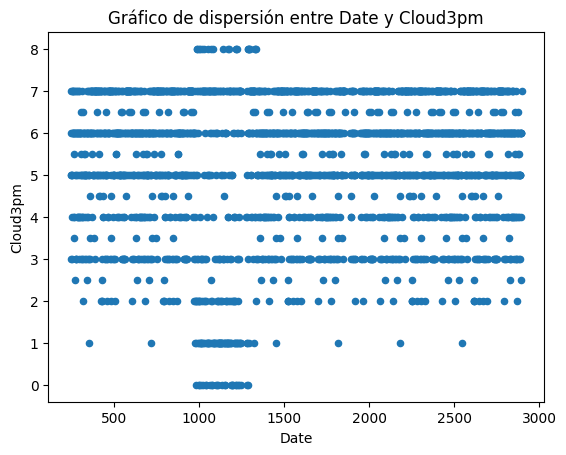

In [522]:
graf_dispersion(df_train_cleared[df_train_cleared['Location'] == 'Adelaide'],'Date','Cloud3pm')

Se hace un conteo de nulos para chequeo:

In [523]:
# Contar el total de filas para Adelaide
total_adelaide = df_train_cleared[df_train_cleared['Location'] == 'Adelaide'].shape[0]
print(f"Total de filas para Adelaide: {total_adelaide}")

# Contar las filas donde 'Cloud9am' es nulo en Adelaide
null_cloud3pm_adelaide = df_train_cleared[df_train_cleared['Location'] == 'Adelaide']['Cloud9am'].isna().sum()
print(f"Filas con 'Cloud9am' nulo en Adelaide: {null_cloud3pm_adelaide}")

# Contar las filas donde 'Cloud3pm' es nulo en Adelaide
null_cloud3pm_adelaide = df_train_cleared[df_train_cleared['Location'] == 'Adelaide']['Cloud3pm'].isna().sum()
print(f"Filas con 'Cloud3pm' nulo en Adelaide: {null_cloud3pm_adelaide}")

Total de filas para Adelaide: 2565
Filas con 'Cloud9am' nulo en Adelaide: 0
Filas con 'Cloud3pm' nulo en Adelaide: 0


Se reemplazan los valores nan de 'Cloud3pm' con los valores de 'Cloud9am'

In [524]:
df_train_cleared.loc[df_train_cleared['Location'] == 'Adelaide', 'Cloud3pm'] = df_train_cleared[df_train_cleared['Location'] == 'Adelaide']['Cloud9am']


In [525]:
analisis_geo_nan(df_train_cleared, 'Cloud3pm', dist_matrix, cities_coords)

,Location,Cloud3pm NaN Count,Nearest City,Distance (km)
0,MountGambier,20,Dartmoor,44.84
1,Dartmoor,14,MountGambier,44.84
2,Cobar,8,Canberra,519.56
3,Melbourne,1,MelbourneAirport,19.32
4,MelbourneAirport,1,Melbourne,19.32


##### Método para Canberra

Se grafican los valores de Cloud9am por date para Canberra, y se observan faltantes entre 650 y 850, principalmente.

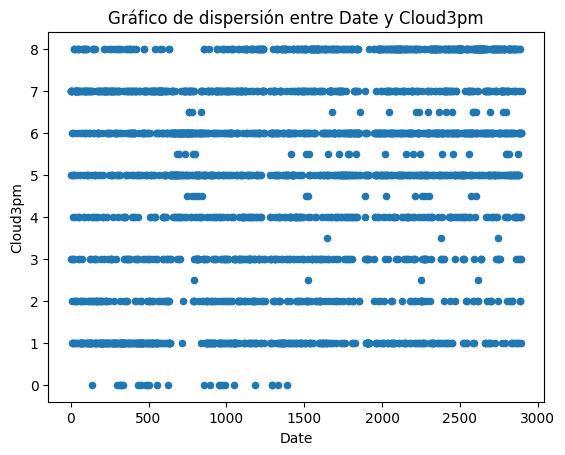

In [526]:
graf_dispersion(df_train_cleared[df_train_cleared['Location'] == 'Canberra'],'Date','Cloud3pm')

Se estudia qué valores se dieron para cada fecha determinada los años sucesivos y/o previos, y se toma la moda y la mediana. Se adoptan los valores predichos por la mediana por presentar un menor mae, y se reemplazan los datos en el dataframe.

In [527]:
# Uso de la función con moda
local_data=predict_variable(df_train_cleared, 'Canberra', 'Cloud3pm', method='mode')

# Uso de la función con mediana
local_data=predict_variable(df_train_cleared, 'Canberra', 'Cloud3pm', method='median')

El Error Medio Absoluto (MAE) para Canberra usando mode es: 2.1087962962962963
El Error Medio Absoluto (MAE) para Canberra usando median es: 1.5979344729344729


In [528]:
df_train_cleared = update_missing_values(df_train_cleared, local_data, 'Cloud3pm')

In [529]:
analisis_geo_nan(df_train_cleared, 'Cloud3pm', dist_matrix, cities_coords)

,Location,Cloud3pm NaN Count,Nearest City,Distance (km)
0,MountGambier,20,Dartmoor,44.84
1,Dartmoor,14,MountGambier,44.84
2,Cobar,8,Canberra,519.56
3,Melbourne,1,MelbourneAirport,19.32
4,MelbourneAirport,1,Melbourne,19.32


#### Análisis nan para Evaporation

In [537]:
analisis_geo_nan(df_train_cleared, 'Evaporation', dist_matrix, cities_coords)

,Location,Evaporation NaN Count,Nearest City,Distance (km)
0,Cobar,77,Canberra,519.56
1,Sydney,37,SydneyAirport,8.49
2,SydneyAirport,32,Sydney,8.49
3,MountGambier,16,Dartmoor,44.84
4,Canberra,15,SydneyAirport,239.41
5,Dartmoor,15,MountGambier,44.84
6,Melbourne,1,MelbourneAirport,19.32
7,MelbourneAirport,1,Melbourne,19.32


In [533]:
comparar_datos(df_train_cleared, 'Adelaide', 'MountGambier', 'Evaporation')
comparar_datos(df_train_cleared, 'Adelaide', 'Dartmoor', 'Evaporation')

Correlación entre Adelaide y MountGambier para Evaporation: 0.5855093212248019
Correlación entre Adelaide y Dartmoor para Evaporation: 0.5841141507641723


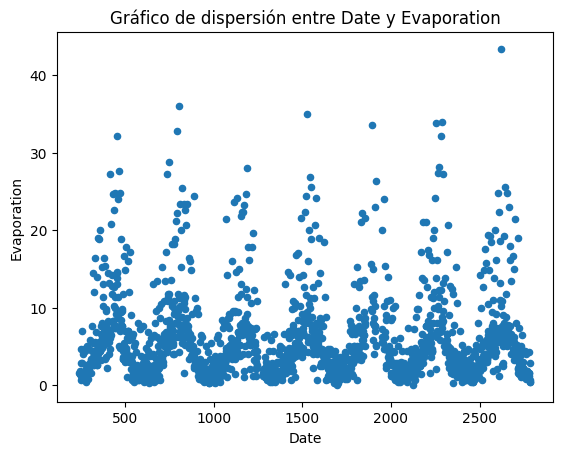

In [534]:
graf_dispersion(df_train_cleared[df_train_cleared['Location'] == 'Adelaide'],'Date','Evaporation')

In [535]:
# Uso de la función con moda
local_data=predict_variable(df_train_cleared, 'Adelaide', 'Evaporation', method='mode')

# Uso de la función con mediana
local_data=predict_variable(df_train_cleared, 'Adelaide', 'Evaporation', method='median')

El Error Medio Absoluto (MAE) para Adelaide usando mode es: 2.9560446009389674
El Error Medio Absoluto (MAE) para Adelaide usando median es: 2.6309565727699527


In [536]:
def update_missing_values(df_main, local_data, variable):
    """
    Actualiza los valores faltantes de una variable en el DataFrame principal usando
    los valores predictivos provenientes de un DataFrame local.
    
    Parámetros:
        df_main (pd.DataFrame): DataFrame principal donde se actualizarán los datos.
        local_data (pd.DataFrame): DataFrame local con datos predictivos.
        variable (str): Nombre de la variable a actualizar.
    """
    # Asegurarse de que el DataFrame local solo contenga las columnas necesarias
    if 'predic' not in variable:
        variable_predic = f'{variable}_predic'
    else:
        variable_predic = variable
        
    local_data = local_data[['Date', 'Location', variable_predic]]

    # Fusionar df_main con local_data para obtener los valores predictivos
    df_main = df_main.merge(local_data, on=['Date', 'Location'], how='left')

    # Actualizar los valores NaN en la variable específica usando los valores predictivos
    df_main[variable] = df_main[variable].fillna(df_main[variable_predic])

    # Opcional: Eliminar la columna predictiva si ya no es necesaria
    df_main.drop(columns=variable_predic, inplace=True)

    return df_main

df_train_cleared = update_missing_values(df_train_cleared, local_data, 'Evaporation')

In [539]:
# Crear una copia del DataFrame sin las columnas 'RainfallTomorrow' y 'RainTomorrow'
df_filtered = df_train_cleared.drop(columns=['RainfallTomorrow', 'RainTomorrow'])

# Contar filas que contienen al menos un valor NaN en el DataFrame filtrado
nan_rows_count_filtered = df_filtered.isna().any(axis=1).sum()
print(f'Número de filas con al menos un valor NaN (sin contar RainTomorrow y RainfallTomorrow): {nan_rows_count_filtered}')

# Cantidad de valores faltantes en el DataFrame filtrado, ordenados de mayor a menor
nan_count_filtered = df_filtered.isna().sum().sort_values(ascending=False)
print(nan_count_filtered)

Número de filas con al menos un valor NaN (sin contar RainTomorrow y RainfallTomorrow): 2470
WindDir9am       878
WindGustDir      792
WindGustSpeed    790
RainToday        742
WindDir3pm       272
Evaporation      194
Rainfall         119
Humidity9am       77
Sunshine          55
Cloud3pm          44
Pressure9am       35
Pressure3pm       32
Humidity3pm       29
WindSpeed9am      28
Temp9am           27
Cloud9am          20
WindSpeed3pm      19
Temp3pm           17
MinTemp            8
MaxTemp            5
Location           0
Date               0
dtype: int64
